In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

ModuleNotFoundError: No module named 'sklearn.utils.testing'

In [2]:
## Constant
RANDOM_STATE = 0

## Read csv file
df = pd.read_csv('train_all_tasks.csv')

## Data pre-processing

In [3]:
# text and labels for task A
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(df['text'], df['label_sexist'], test_size=0.3, random_state=RANDOM_STATE)
X_test_a, X_dev_a, y_test_a, y_dev_a = train_test_split(X_test_a, y_test_a, test_size=0.33)

# text and labels for task B
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df['text'], df['label_category'], test_size=0.3, random_state=RANDOM_STATE)
X_test_b, X_dev_b, y_test_b, y_dev_b = train_test_split(X_test_b, y_test_b, test_size=0.33, random_state=RANDOM_STATE)

X_train_b2, X_test_b2, y_train_b2, y_test_b2 = train_test_split(df[df['label_sexist'] == 'sexist']['text'],
                                                                df[df['label_sexist'] == 'sexist']['label_category'],
                                                                test_size=0.3,
                                                                random_state=RANDOM_STATE)
X_test_b2, X_dev_b2, y_test_b2, y_dev_b2 = train_test_split(X_test_b2, y_test_b2, test_size=0.33, random_state=RANDOM_STATE)

In [4]:
print(Counter(y_train_a))
print(Counter(y_dev_a))
print(Counter(y_test_a))
print("")
print(Counter(y_train_b))
print(Counter(y_dev_b))
print(Counter(y_test_b))
print("")
print(Counter(y_train_b2))
print(Counter(y_dev_b2))
print(Counter(y_test_b2))

Counter({'not sexist': 7413, 'sexist': 2387})
Counter({'not sexist': 1060, 'sexist': 326})
Counter({'not sexist': 2129, 'sexist': 685})

Counter({'none': 7413, '2. derogation': 1119, '3. animosity': 808, '4. prejudiced discussions': 236, '1. threats, plans to harm and incitement': 224})
Counter({'none': 1058, '2. derogation': 159, '3. animosity': 116, '4. prejudiced discussions': 27, '1. threats, plans to harm and incitement': 26})
Counter({'none': 2131, '2. derogation': 312, '3. animosity': 241, '4. prejudiced discussions': 70, '1. threats, plans to harm and incitement': 60})

Counter({'2. derogation': 1107, '3. animosity': 812, '1. threats, plans to harm and incitement': 231, '4. prejudiced discussions': 228})
Counter({'2. derogation': 157, '3. animosity': 115, '4. prejudiced discussions': 37, '1. threats, plans to harm and incitement': 28})
Counter({'2. derogation': 326, '3. animosity': 238, '4. prejudiced discussions': 68, '1. threats, plans to harm and incitement': 51})


In [5]:
def confmatrix_display(confmatrix, model_name, task_name):
    plt.rcParams.update({'font.size': 12})
    plt.figure(dpi=1200)

    if task_name == 'taskA':
        labels = df['label_sexist'].unique() 
    elif task_name == 'taskB':
        labels = df['label_category'].sort_values().unique()
        labels[0] = '1. threats...'
    else:
        labels = df[df['label_sexist'] == 'sexist']['label_category'].sort_values().unique()
        labels[0] = '1. threats...'

    cm_display = ConfusionMatrixDisplay(confmatrix, display_labels=labels).plot()
    # cm_display = ConfusionMatrixDisplay(confmatrix).plot()
    
    if task_name != 'taskA':
        plt.xticks(rotation=45, ha='right')

In [6]:
def report(model_name, ydev, pred, task_name, zero_division=1):
    conf_matrix = confusion_matrix(ydev, pred)
    print("\n=== {0} ===\n\nClassification Report:\n{1}"
          "\nConfusion Matrix:\n{2}".format(model_name,
                                            classification_report(ydev, pred, 
                                                                  zero_division=zero_division),
                                            confusion_matrix(ydev, pred)))

    confmatrix_display(conf_matrix, model_name, task_name)

In [7]:
def naive_bayes(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "naive bayes"
  model = MultinomialNB()
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [8]:
def svm_train(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "SVM"
  model = SVC(kernel='linear', random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [9]:
def majority_class(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "majority class"
  model = DummyClassifier(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name, zero_division=0)

In [10]:
def decision_tree_train(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "decision tree"
  model = DecisionTreeClassifier(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [11]:
@ignore_warnings(category=ConvergenceWarning)
def logistic_regression(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "logistic regression"
  model = LogisticRegression(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [12]:
from sklearn.ensemble import StackingClassifier

@ignore_warnings(category=ConvergenceWarning)
def stacking_classifier(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "stacking classifier"

  estimators = [('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
                ('svc', SVC(kernel='linear', random_state=RANDOM_STATE)),
                ('nb', MultinomialNB()),
                ('lr', LogisticRegression(random_state=RANDOM_STATE))]
  model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=RANDOM_STATE))


  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

## Running Task A (Binary) 

In [13]:
task_name = 'taskA'
le = LabelEncoder()

le.fit(y_train_a)
y_train_a = le.transform(y_train_a)


=== naive bayes ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.82      0.96      0.89      2129
      sexist       0.74      0.36      0.49       685

    accuracy                           0.81      2814
   macro avg       0.78      0.66      0.69      2814
weighted avg       0.80      0.81      0.79      2814

Confusion Matrix:
[[2040   89]
 [ 436  249]]


<Figure size 7200x4800 with 0 Axes>

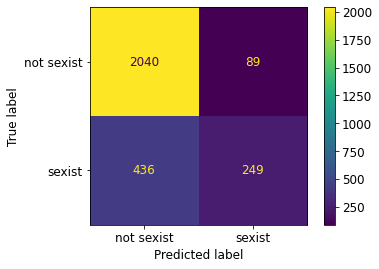

In [14]:
naive_bayes(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)


=== majority class ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.76      1.00      0.86      2129
      sexist       0.00      0.00      0.00       685

    accuracy                           0.76      2814
   macro avg       0.38      0.50      0.43      2814
weighted avg       0.57      0.76      0.65      2814

Confusion Matrix:
[[2129    0]
 [ 685    0]]


<Figure size 7200x4800 with 0 Axes>

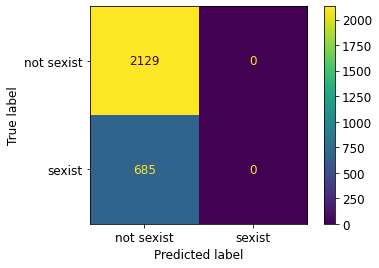

In [15]:
majority_class(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)


=== SVM ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.86      0.89      0.87      2129
      sexist       0.61      0.55      0.58       685

    accuracy                           0.81      2814
   macro avg       0.74      0.72      0.73      2814
weighted avg       0.80      0.81      0.80      2814

Confusion Matrix:
[[1889  240]
 [ 306  379]]


<Figure size 7200x4800 with 0 Axes>

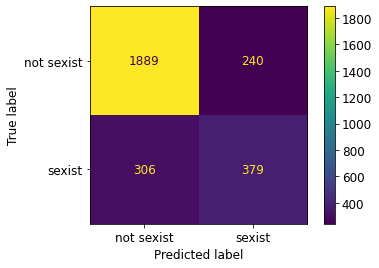

In [16]:
svm_train(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)


=== decision tree ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.85      0.88      0.87      2129
      sexist       0.59      0.53      0.56       685

    accuracy                           0.80      2814
   macro avg       0.72      0.71      0.71      2814
weighted avg       0.79      0.80      0.79      2814

Confusion Matrix:
[[1875  254]
 [ 320  365]]


<Figure size 7200x4800 with 0 Axes>

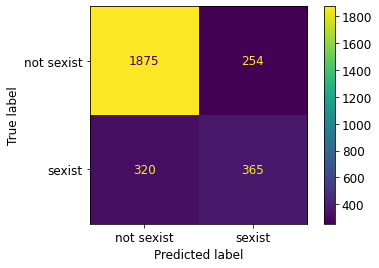

In [17]:
decision_tree_train(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

/home/andre/miniconda3/envs/lfd/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== logistic regression ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.85      0.94      0.89      2129
      sexist       0.73      0.51      0.60       685

    accuracy                           0.83      2814
   macro avg       0.79      0.72      0.75      2814
weighted avg       0.82      0.83      0.82      2814

Confusion Matrix:
[[1998  131]
 [ 339  346]]


<Figure size 7200x4800 with 0 Axes>

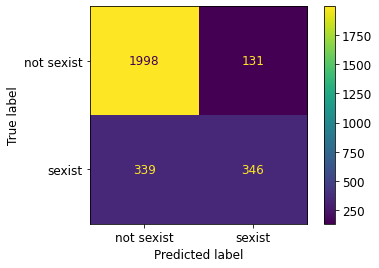

In [18]:
logistic_regression(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

/home/andre/miniconda3/envs/lfd/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/andre/miniconda3/envs/lfd/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode


=== stacking classifier ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.85      0.95      0.90      2129
      sexist       0.77      0.49      0.60       685

    accuracy                           0.84      2814
   macro avg       0.81      0.72      0.75      2814
weighted avg       0.83      0.84      0.83      2814

Confusion Matrix:
[[2031   98]
 [ 349  336]]


<Figure size 7200x4800 with 0 Axes>

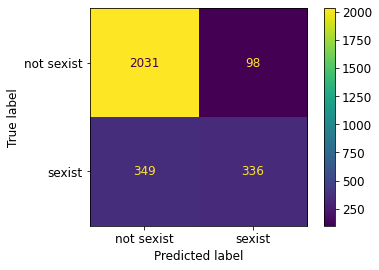

In [19]:
stacking_classifier(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

## Running Task B (Multi-class) 

In [20]:
task_name = 'taskB'

le.fit(y_train_b)
y_train_b = le.transform(y_train_b)


=== naive bayes ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       1.00      0.00      0.00        60
                           2. derogation       0.52      0.12      0.19       312
                            3. animosity       0.17      0.00      0.01       241
               4. prejudiced discussions       1.00      0.00      0.00        70
                                    none       0.77      0.99      0.87      2131

                                accuracy                           0.77      2814
                               macro avg       0.69      0.22      0.21      2814
                            weighted avg       0.70      0.77      0.68      2814

Confusion Matrix:
[[   0    2    0    0   58]
 [   0   36    4    0  272]
 [   0   19    1    0  221]
 [   0    0    0    0   70]
 [   0   12    1    0 2118]]


<Figure size 7200x4800 with 0 Axes>

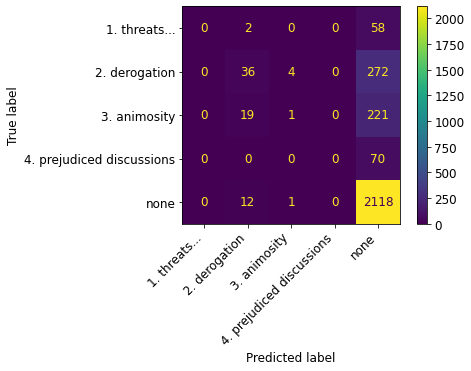

In [21]:
naive_bayes(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)


=== majority class ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00        60
                           2. derogation       0.00      0.00      0.00       312
                            3. animosity       0.00      0.00      0.00       241
               4. prejudiced discussions       0.00      0.00      0.00        70
                                    none       0.76      1.00      0.86      2131

                                accuracy                           0.76      2814
                               macro avg       0.15      0.20      0.17      2814
                            weighted avg       0.57      0.76      0.65      2814

Confusion Matrix:
[[   0    0    0    0   60]
 [   0    0    0    0  312]
 [   0    0    0    0  241]
 [   0    0    0    0   70]
 [   0    0    0    0 2131]]


<Figure size 7200x4800 with 0 Axes>

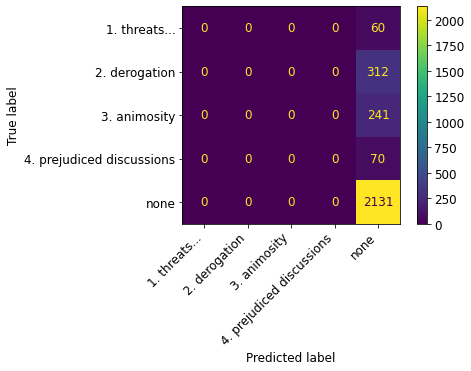

In [22]:
majority_class(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)


=== SVM ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.14      0.12      0.13        60
                           2. derogation       0.34      0.37      0.36       312
                            3. animosity       0.35      0.24      0.28       241
               4. prejudiced discussions       0.22      0.14      0.17        70
                                    none       0.86      0.89      0.87      2131

                                accuracy                           0.74      2814
                               macro avg       0.38      0.35      0.36      2814
                            weighted avg       0.72      0.74      0.73      2814

Confusion Matrix:
[[   7    9    6    3   35]
 [   7  115   40    6  144]
 [   8   75   57    4   97]
 [   1    7    6   10   46]
 [  26  128   53   22 1902]]


<Figure size 7200x4800 with 0 Axes>

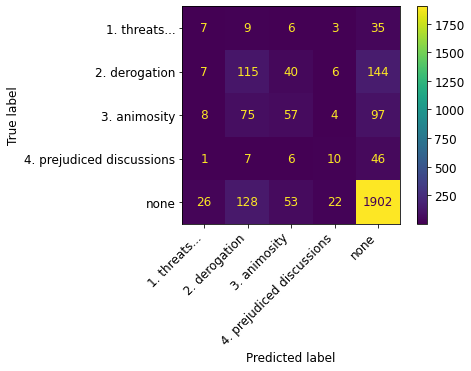

In [23]:
svm_train(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)


=== decision tree ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.16      0.12      0.13        60
                           2. derogation       0.33      0.29      0.31       312
                            3. animosity       0.34      0.25      0.29       241
               4. prejudiced discussions       0.17      0.06      0.09        70
                                    none       0.84      0.91      0.88      2131

                                accuracy                           0.75      2814
                               macro avg       0.37      0.32      0.34      2814
                            weighted avg       0.71      0.75      0.73      2814

Confusion Matrix:
[[   7    9    9    0   35]
 [   7   90   52    4  159]
 [   2   57   61    2  119]
 [   2   13    8    4   43]
 [  27  106   48   14 1936]]


<Figure size 7200x4800 with 0 Axes>

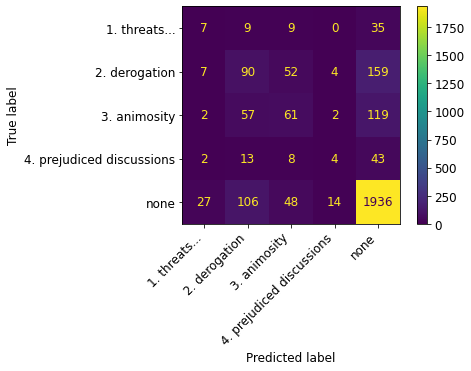

In [24]:
decision_tree_train(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

/home/andre/miniconda3/envs/lfd/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== logistic regression ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.21      0.05      0.08        60
                           2. derogation       0.40      0.32      0.36       312
                            3. animosity       0.40      0.20      0.26       241
               4. prejudiced discussions       0.27      0.10      0.15        70
                                    none       0.84      0.95      0.89      2131

                                accuracy                           0.77      2814
                               macro avg       0.43      0.32      0.35      2814
                            weighted avg       0.73      0.77      0.74      2814

Confusion Matrix:
[[   3    9    4    1   43]
 [   3  100   39    5  165]
 [   3   64   47    4  123]
 [   0    6    3    7   54]
 [   5   70   24    9 2023]]


<Figure size 7200x4800 with 0 Axes>

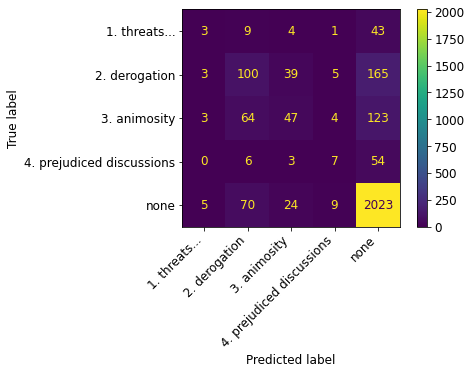

In [25]:
logistic_regression(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

## Running Task B version 2 (Multi-class, without a none class) 

In [26]:
task_name = 'taskB2'

le.fit(y_train_b2)
y_train_b2 = le.transform(y_train_b2)


=== naive bayes ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       1.00      0.10      0.18        51
                           2. derogation       0.53      0.84      0.65       326
                            3. animosity       0.46      0.30      0.36       238
               4. prejudiced discussions       0.75      0.04      0.08        68

                                accuracy                           0.52       683
                               macro avg       0.68      0.32      0.32       683
                            weighted avg       0.56      0.52      0.46       683

Confusion Matrix:
[[  5  32  14   0]
 [  0 273  52   1]
 [  0 167  71   0]
 [  0  48  17   3]]


<Figure size 7200x4800 with 0 Axes>

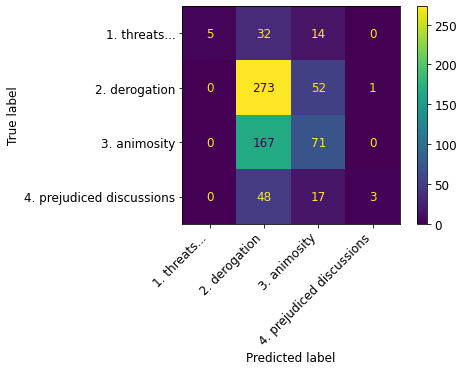

In [27]:
naive_bayes(X_train_b2, y_train_b2, X_test_b2, y_test_b2, le, task_name)


=== majority class ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00        51
                           2. derogation       0.48      1.00      0.65       326
                            3. animosity       0.00      0.00      0.00       238
               4. prejudiced discussions       0.00      0.00      0.00        68

                                accuracy                           0.48       683
                               macro avg       0.12      0.25      0.16       683
                            weighted avg       0.23      0.48      0.31       683

Confusion Matrix:
[[  0  51   0   0]
 [  0 326   0   0]
 [  0 238   0   0]
 [  0  68   0   0]]


<Figure size 7200x4800 with 0 Axes>

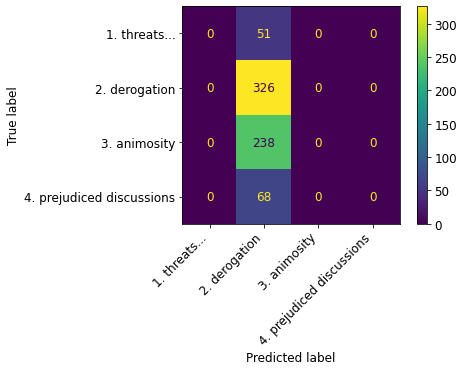

In [28]:
majority_class(X_train_b2, y_train_b2, X_test_b2, y_test_b2, le, task_name)


=== SVM ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.39      0.53      0.45        51
                           2. derogation       0.55      0.57      0.56       326
                            3. animosity       0.44      0.43      0.44       238
               4. prejudiced discussions       0.27      0.18      0.21        68

                                accuracy                           0.48       683
                               macro avg       0.41      0.43      0.41       683
                            weighted avg       0.47      0.48      0.47       683

Confusion Matrix:
[[ 27   7  12   5]
 [ 26 185 100  15]
 [ 13 110 103  12]
 [  4  33  19  12]]


<Figure size 7200x4800 with 0 Axes>

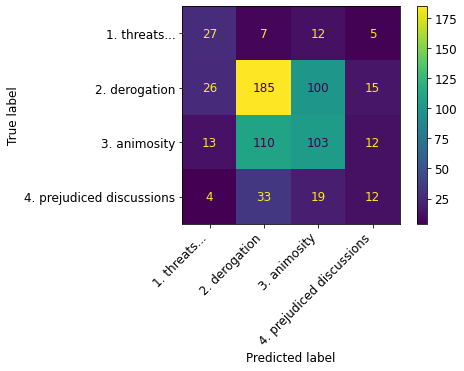

In [29]:
svm_train(X_train_b2, y_train_b2, X_test_b2, y_test_b2, le, task_name)


=== decision tree ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.26      0.27      0.27        51
                           2. derogation       0.53      0.54      0.54       326
                            3. animosity       0.47      0.47      0.47       238
               4. prejudiced discussions       0.19      0.18      0.18        68

                                accuracy                           0.46       683
                               macro avg       0.36      0.37      0.36       683
                            weighted avg       0.46      0.46      0.46       683

Confusion Matrix:
[[ 14  19  13   5]
 [ 19 177  95  35]
 [ 16  99 111  12]
 [  4  36  16  12]]


<Figure size 7200x4800 with 0 Axes>

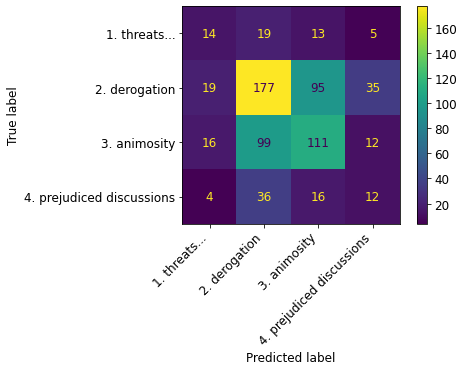

In [30]:
decision_tree_train(X_train_b2, y_train_b2, X_test_b2, y_test_b2, le, task_name)


=== logistic regression ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.52      0.43      0.47        51
                           2. derogation       0.57      0.64      0.60       326
                            3. animosity       0.46      0.46      0.46       238
               4. prejudiced discussions       0.32      0.18      0.23        68

                                accuracy                           0.52       683
                               macro avg       0.47      0.43      0.44       683
                            weighted avg       0.50      0.52      0.51       683

Confusion Matrix:
[[ 22   9  15   5]
 [ 12 208  97   9]
 [  5 111 110  12]
 [  3  37  16  12]]


/home/andre/miniconda3/envs/lfd/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 7200x4800 with 0 Axes>

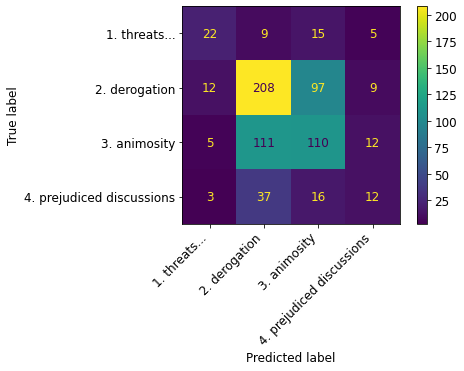

In [31]:
logistic_regression(X_train_b2, y_train_b2, X_test_b2, y_test_b2, le, task_name)

In [33]:
stacking_classifier(X_train_b2, y_train_b2, X_test_b2, y_test_b2, le, task_name)

/home/andre/miniconda3/envs/lfd/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 